## To use:
Execute all cells below to load libraries and function definitions.  
Under the 'Plot' heading, execute the blocks to make predictions, change the parameters of Random Forest, make plots, and view correlations.

In [1]:
# import required libs
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import copy
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, kendalltau
from statistics import median, mean

# Load Data

In [83]:
gdata = pd.read_pickle('./pickle/gdata_aoa.p')

hdata = pd.read_pickle('./pickle/hdata_aoa.p')

# Random Forest

In [84]:
def ranfor(df,train_size=0.8,n_estimators=150,criterion='mse',features=['degree','len','logfreq']):
    # select features for training
    X = df[features]
    y = df['age']
    # scale the data
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size)
    # train the regressor model
    ran_for_reg = RandomForestRegressor(n_estimators=n_estimators,
                                    criterion=criterion
                                   ).fit(X_train,y_train)
    pred = ran_for_reg.predict(X_test)
    true = y_test.to_numpy()
    return (pred,true)

### Calculate correlation values between predicted and true data

In [85]:
def calc_correlations(pred,true):
    correlations = {}
    correlations['mse'] = mean_squared_error(pred,true)
    correlations['ktau'] = kendalltau(pred,true)[0]
    correlations['pval-ktau'] = kendalltau(pred,true)[1]
    correlations['pearsonr'] = pearsonr(pred,true)[0]
    correlations['pval-pearsonr'] = pearsonr(pred,true)[1]
    correlations['r2'] = r2_score(true, pred)
    return correlations

In [86]:
def pretty_corr(c): # pretty print output from calc_correlations()
    print(f"""
    Mean squared error (RMS): \t{c['mse']:.5f}\t({(c['mse']**.5):.5})
    Kendall Tau: \t\t{c['ktau']:.5}
    \tKtau p-value: \t\t{c['pval-ktau']:.5}
    Pearson's r: \t\t{c['pearsonr']:.5}
    \tPearson's r p-value: \t{c['pval-pearsonr']:.5}
    Coef. of determination \t{c['r2']:.5}
    """)

### Calculate the averages, given a list of dictionaries from the output of calc_correlations()

In [87]:
def met_avgs(met_list) -> dict: # given a list of dictionaries of metrics, return a dict of their averages
    keys = met_list[0].keys()
    list_len = len(met_list)
    ret_dict = {}
    for k in keys:
        ret_dict[k] = 0
    for d in met_list:
        for m in d:
            ret_dict[m] += d[m]
    for m in ret_dict:
        ret_dict[m]/=list_len
    
    return ret_dict

# Plots

In [88]:
n_t = 150 # number of trees in the random forest regressor
ts = 0.8 # size of the training data in train_test_split

In [89]:
h_corr = []
g_corr = []
for i in range(5): # change to average over many iterations
    pairwise_results = ranfor(gdata,n_estimators = n_t, train_size = ts)
    hypergraph_results = ranfor(hdata,n_estimators = n_t, train_size = ts)
    hyp_pred, hyp_true = hypergraph_results
    gra_pred, gra_true = pairwise_results

    hyp_corr = calc_correlations(hyp_pred,hyp_true)
    graph_corr = calc_correlations(gra_pred,gra_true)
    h_corr.append(hyp_corr)
    g_corr.append(graph_corr)
    
avg_hyp_corr = met_avgs(h_corr) # take average of all the correlation values calculated
avg_graph_corr = met_avgs(g_corr)

### Print results

In [95]:
# Pretty print the correlations
print("-----------------------------------------")
print("Hypergraph ranking correlations:")
pretty_corr(avg_hyp_corr)
print("-----------------------------------------")
print("Pair graph ranking correlations:")
pretty_corr(avg_graph_corr)

-----------------------------------------
Hypergraph ranking correlations:

    Mean squared error (RMS): 	1.58371	(1.2585)
    Kendall Tau: 		0.3807
    	Ktau p-value: 		1.333e-86
    Pearson's r: 		0.59146
    	Pearson's r p-value: 	3.1665e-114
    Coef. of determination 	0.33432
    
-----------------------------------------
Pair graph ranking correlations:

    Mean squared error (RMS): 	1.74240	(1.32)
    Kendall Tau: 		0.31144
    	Ktau p-value: 		1.3976e-58
    Pearson's r: 		0.52987
    	Pearson's r p-value: 	6.8048e-88
    Coef. of determination 	0.24697
    


In [96]:
#get coefficients for line of best fit
hm, hb = np.polyfit(hyp_true,hyp_pred,1)
gm, gb = np.polyfit(gra_true,gra_pred,1)

[Text(0.5, 0, 'Empirical Age'),
 Text(0.5, 1.0, 'Pairwise Graph'),
 (2.0, 9.0),
 None]

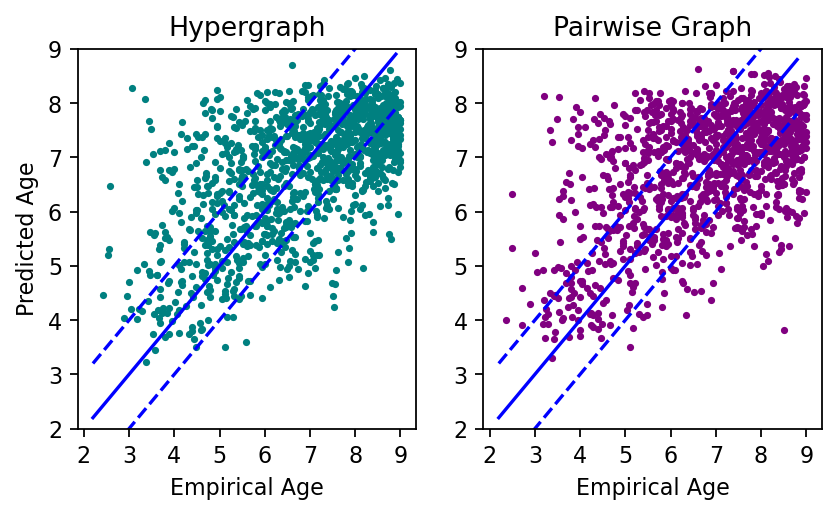

In [97]:
_, (ax1, ax2) = plt.subplots(1, 2, dpi=160)

ax1.scatter(hyp_true,hyp_pred, c='teal', s=5)
ax1.plot([2.2,8.9],[2.2,8.9],c='b')
ax1.plot([2.2,8.9],[3.2,9.9],ls='--',c='b')
ax1.plot([2.2,8.9],[1.2,7.9],ls='--',c='b')
#ax1.plot(hyp_true,hm*hyp_true+hb,c='red') # uncomment for line of best fit
ax1.set(xlabel='Empirical Age',ylabel='Predicted Age',title='Hypergraph',
        ylim=[2,9],xticks=list(range(2,10)),aspect=1.2)

ax2.scatter(gra_true,gra_pred, c='purple', s=5)
ax2.plot([2.2,8.8],[2.2,8.8],c='b')
ax2.plot([2.2,8.8],[3.2,9.8],ls='--',c='b')
ax2.plot([2.2,8.8],[1.2,7.8],ls='--',c='b')
#ax2.plot(gra_true,gm*gra_true+gb,c='red') # uncomment for line of best fit
ax2.set(xlabel='Empirical Age',title='Pairwise Graph',
        ylim=[2,9],xticks=list(range(2,10)),aspect=1.2)

### Calculate how many predicted values are within 'epsilon' of the true value

In [5]:
def pred_in_eps(pred,true,eps): # returns list of True/False values indicating for each predicted value if it falls within eps of the true value
    res = []
    #for n in range(len(pred)):
    #    res.append(True if np.abs(pred[n]-true[n])<eps else False)
    
    res = [True if np.abs(pred[n]-true[n])<eps else False for n in range(len(pred))]
    
    return res

In [3]:
f = lambda x: 100*sum(pred_in_eps(hyp_pred,hyp_true,x))/len(hyp_pred)
g = lambda x: 100*sum(pred_in_eps(gra_pred,gra_true,x))/len(gra_pred)

In [4]:
f(1) # percentage of results within +/- 1 of true value on hypergraph model

NameError: name 'pred_in_eps' is not defined

In [93]:
g(1) # percentage of results within +/- 1 of true value on graph model

56.70274771024147

In [2]:
x = np.linspace(0,4,100)
y1 = [f(a) for a in x]
y2 = [g(a) for a in x]
plt.figure(dpi=100)
plt.xlabel('epsilon')
plt.ylabel('correctly predicted within epsilon (%)')
plt.yticks(ticks=range(0,101,10))
plt.grid(visible=True,which='both')
plt.plot(x, y1, c='green', label='hypergraph')
plt.plot(x, y2, c='purple', label='graph')
plt.legend(loc='lower right')

NameError: name 'f' is not defined